In [1]:
#https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/

In [113]:
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot

In [114]:
ab_path='../data/SPY-Daily-Y09-Now.csv'

start_date='2012-01-01'
end_date='2022-12-31'

prediction_col='Price'
#my_features=['Price', 'EMA1', 'MACD', 'RSI']

In [115]:
dataset=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
dataset.rename(columns={'Date/Time':'Date'},inplace=True)
dataset.set_index('Date',inplace=True)
dataset.sort_index(inplace=True)
dataset=dataset.loc[start_date:end_date,[prediction_col]]
dataset.info()
dataset.head()

# line plot


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2743 entries, 2012-01-03 to 2022-11-23
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2743 non-null   float64
dtypes: float64(1)
memory usage: 42.9 KB


,Price
Date,
2012-01-03,127.50
2012-01-04,127.70
2012-01-05,128.04
2012-01-06,127.71
2012-01-09,128.02


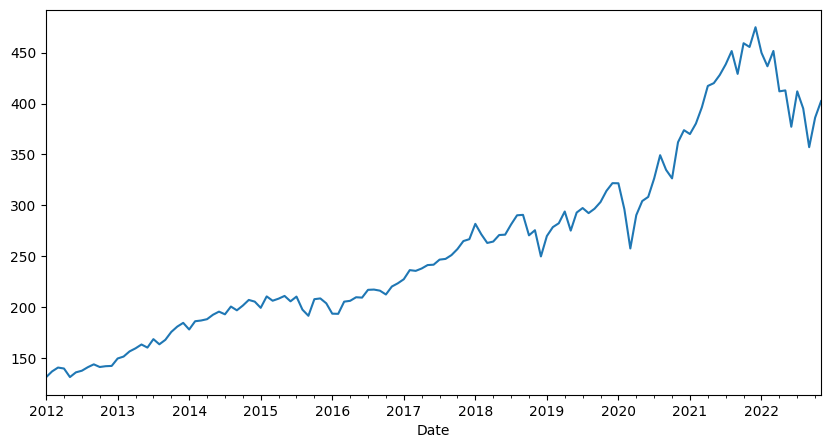

In [117]:
dataset.resample( 'M').last()[prediction_col].plot(figsize=(10,5))
pyplot.show()

In [118]:
# convert time series into supervised learning and split data
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [128]:
n_lag =25
n_seq = 5
n_test_ratio = 0.1



raw_values = dataset[prediction_col].values
n_test=int(len(raw_values)*n_test_ratio)

#print(raw_values[:3])
raw_values = raw_values.reshape(len(raw_values), 1)
print("Raws data :",raw_values.shape)
print(raw_values[:5])

print("Series to supervised trasformation")
supervised = series_to_supervised(raw_values, n_lag, n_seq)
supervised_values = supervised.values

train, test = supervised_values[0:-n_test], supervised_values[-n_test:]

print("All supervised :" ,supervised_values.shape)
print(supervised_values[:3])

print("train :" ,train.shape)
print("test :" ,test.shape)

Raws data : (2743, 1)
[[127.5 ]
 [127.7 ]
 [128.04]
 [127.71]
 [128.02]]
Series to supervised trasformation
All supervised : (2714, 30)
[[127.5  127.7  128.04 127.71 128.02 129.13 129.2  129.51 128.84 129.34
  130.77 131.46 131.95 131.61 131.46 132.56 131.88 131.82 131.37 131.32
  132.47 132.68 134.54 134.45 134.79 135.19 135.36 134.36 135.36 135.19]
 [127.7  128.04 127.71 128.02 129.13 129.2  129.51 128.84 129.34 130.77
  131.46 131.95 131.61 131.46 132.56 131.88 131.82 131.37 131.32 132.47
  132.68 134.54 134.45 134.79 135.19 135.36 134.36 135.36 135.19 134.56]
 [128.04 127.71 128.02 129.13 129.2  129.51 128.84 129.34 130.77 131.46
  131.95 131.61 131.46 132.56 131.88 131.82 131.37 131.32 132.47 132.68
  134.54 134.45 134.79 135.19 135.36 134.36 135.36 135.19 134.56 136.05]]
train : (2449, 30)
test : (265, 30)


In [129]:
# make a persistence forecast
def persistence(last_ob, n_seq):
	return [last_ob for i in range(n_seq)]

# evaluate the persistence model
def make_forecasts(train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = persistence(X[-1], n_seq)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

forecasts = make_forecasts(train, test, n_lag, n_seq)

In [130]:
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = test[:,(n_lag+i)]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))
        
evaluate_forecasts(test, forecasts,  n_lag, n_seq)



t+1 RMSE: 6.069794
t+2 RMSE: 8.593465
t+3 RMSE: 10.353433
t+4 RMSE: 11.859976
t+5 RMSE: 13.183282


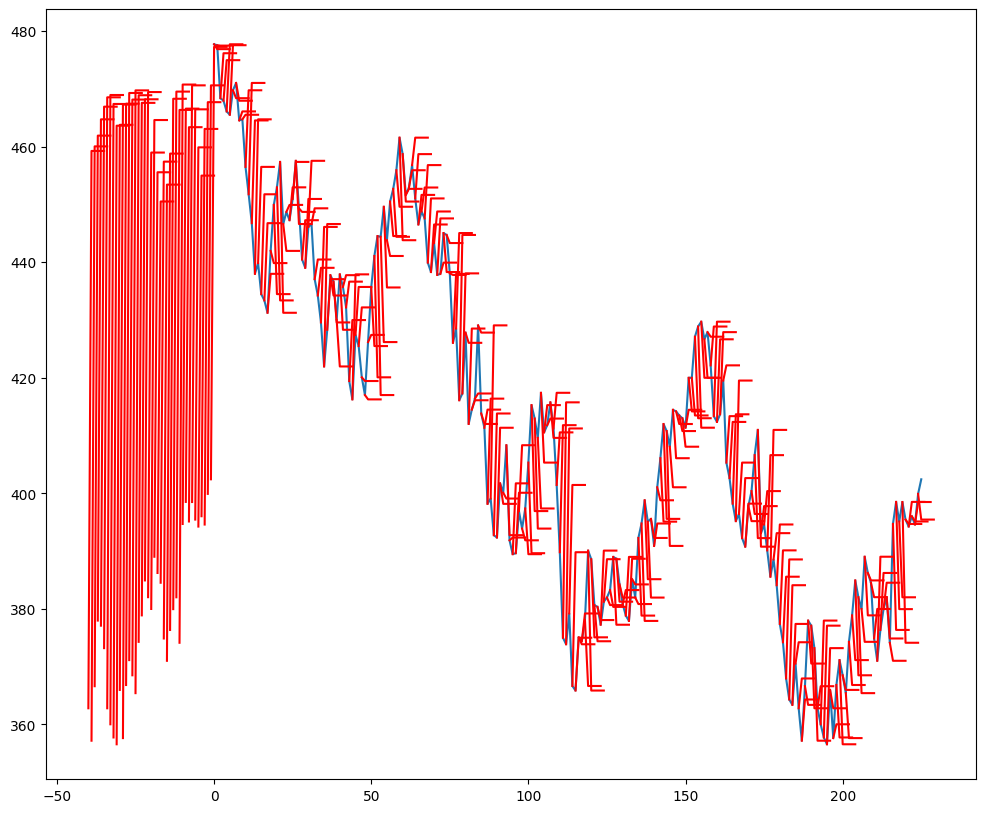

In [131]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.figure(figsize=(12,10))
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

plot_forecasts(dataset.loc['2022-01':'2022-12',:][prediction_col], forecasts, n_test)

